# 1. Setting Up Your A/B Testing Project in Python

In [63]:
import numpy as np #In A/B testing, we use arrays to store group data like conversions, counts, etc.
import pandas as pd #Pandas makes it super easy to organize and explore your A/B test data.
import matplotlib.pyplot as plt #Visualizing conversion rates or differences between groups
import seaborn as sns
from scipy import stats #This lets you analyze your A/B results and decide if there’s a real effect or just random noise.
                        #Running hypothesis tests
                        #Calculating p-values and confidence intervals
                        #Testing if differences between groups are significant
from statsmodels.stats.proportion import proportions_ztest

# 2. Simulating A/B Test Results

In [64]:
np.random.seed(42)
# Assume 10,000 visitors each
n_A, p_A = 10_000, 0.10   # Variant A: 10% true conversion
n_B, p_B = 10_000, 0.12   # Variant B: 12% true conversion

# Simulate number of purchases
success_A = np.random.binomial(n_A, p_A)
success_B = np.random.binomial(n_B, p_B)
print(success_A)
print(success_B)


973
1134


# 3. Calculate Conversion Rate & Confidence Interval for A/B Testing

In [65]:
def proportion_ci(successes, n, alpha=0.05):
    p_hat = successes / n
    z = stats.norm.ppf(1 - alpha/2)
    se = np.sqrt(p_hat * (1 - p_hat) / n)
    return p_hat, p_hat - z*se, p_hat + z*se

p_A_hat, ci_low_A, ci_high_A = proportion_ci(success_A, n_A)
p_B_hat, ci_low_B, ci_high_B = proportion_ci(success_B, n_B)



In [66]:
results = pd.DataFrame({
    'Variant':       ['A', 'B'],
    'Visitors':      [n_A, n_B],
    'Conversions':   [success_A, success_B],
    'CR (p̂)':       [p_A_hat*100, p_B_hat*100],
    'CI Lower (95%)':[ci_low_A*100, ci_low_B*100],
    'CI Upper (95%)':[ci_high_A*100, ci_high_B*100],
})
print(results)
print('''
What Each Column Means
Variant: A = original version, B = new version being tested
Visitors: Number of users shown that version (10,000 each)
Conversions: How many of them took the desired action (e.g., clicked, signed up)
CR (p̂): “Conversion Rate” — the percentage of visitors who converted
CI Lower & Upper (95%): The lower and upper bounds of the 95% confidence interval, which gives a range of where the true conversion rate is likely to 
fall.

''')

  Variant  Visitors  Conversions  CR (p̂)  CI Lower (95%)  CI Upper (95%)
0       A     10000          973     9.73        9.149134       10.310866
1       B     10000         1134    11.34       10.718532       11.961468

What Each Column Means
Variant: A = original version, B = new version being tested
Visitors: Number of users shown that version (10,000 each)
Conversions: How many of them took the desired action (e.g., clicked, signed up)
CR (p̂): “Conversion Rate” — the percentage of visitors who converted
CI Lower & Upper (95%): The lower and upper bounds of the 95% confidence interval, which gives a range of where the true conversion rate is likely to 
fall.




# 4. Visualizing A/B Test Results with Confidence Intervals 

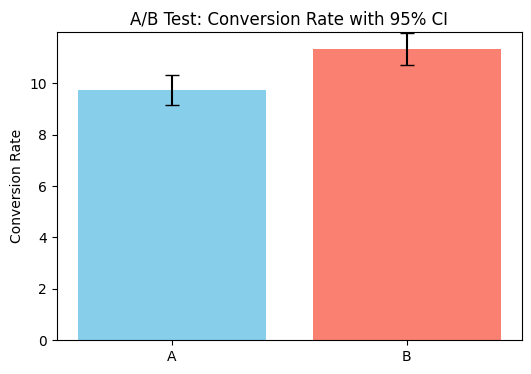

In [67]:
plt.figure(figsize=(6,4))
plt.bar(
    results['Variant'],
    results['CR (p̂)'],
    yerr=[
        results['CR (p̂)'] - results['CI Lower (95%)'],
        results['CI Upper (95%)'] - results['CR (p̂)']
    ],
    capsize=5,
    color=['skyblue','salmon']
)
plt.ylabel('Conversion Rate')
plt.title('A/B Test: Conversion Rate with 95% CI')
plt.ylim(0, max(results['CI Upper (95%)']) + 0.02)
plt.show()

# 5. Testing If Variant B is Statistically Better (Z-Test for Proportions)

In [68]:
# Test H0: p_B ≤ p_A  vs  H1: p_B > p_A
count = np.array([success_B, success_A])
nobs  = np.array([n_B, n_A])

z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')
print(f"Z‐statistic: {z_stat:.3f}")
print(f"P‐value:     {p_value:.3f}")

if p_value < 0.05:
    print("→ Reject H0: Variant B has a significantly higher conversion rate.")
else:
    print("→ Fail to reject H0: No significant lift from B over A.")

Z‐statistic: 3.708
P‐value:     0.000
→ Reject H0: Variant B has a significantly higher conversion rate.


# 6. Real-Time Monitoring & Sequential Testing¶

In [69]:
import numpy as np, matplotlib.pyplot as plt, time
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import clear_output

# Use the same true rates from above
true_p_A, true_p_B = 0.10, 0.12
batch_size = 100       # visitors per batch per variant
n_batches  = 60        # simulate 60 time steps (e.g. minutes)

# Initialize counters
n_visits_A = n_visits_B = 0
n_succ_A   = n_succ_B   = 0

# Lists to store metrics for plotting
batches   = []
p_values  = []
lifts     = []

# 7. Preparing to Simulate A/B Test Results Over Time 

In [70]:
import numpy as np, matplotlib.pyplot as plt, time
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import clear_output

# Use the same true rates from above
true_p_A, true_p_B = 0.10, 0.12
batch_size = 100       # visitors per batch per variant
n_batches  = 60        # simulate 60 time steps (e.g. minutes)

# Initialize counters
n_visits_A = n_visits_B = 0
n_succ_A   = n_succ_B   = 0

# Lists to store metrics for plotting
batches   = []
p_values  = []
lifts     = []

# 8. Simulating a Live A/B Test and Watching Results Over Time

Batch 60/60
  Variant A: 6000 visits, 574 buys → CR = 9.567%
  Variant B: 6000 visits, 714 buys → CR = 11.900%
  Observed lift: 2.333%
  z-stat = 4.13, p-value = 0.0000
  → Significant lift detected (p<0.05).


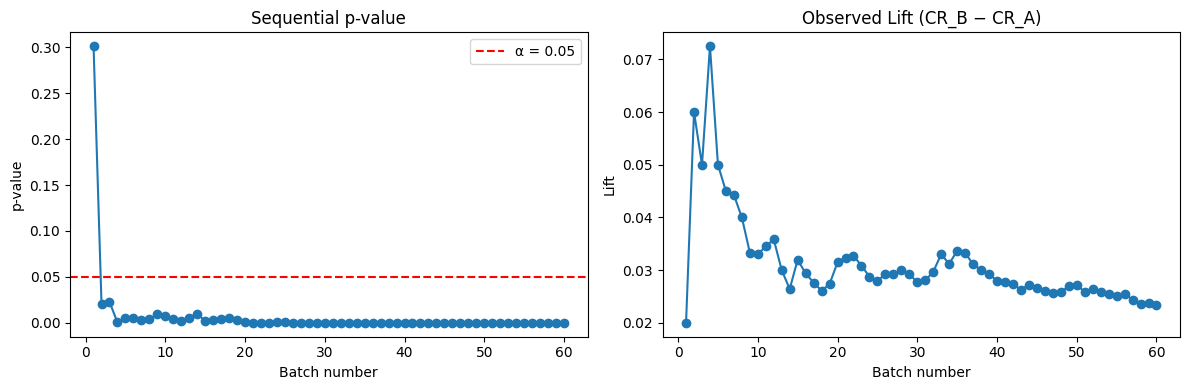

In [71]:
for batch in range(1, n_batches+1):
    # Simulate one batch of visitors
    new_A = np.random.binomial(batch_size, true_p_A)
    new_B = np.random.binomial(batch_size, true_p_B)

    # Update totals
    n_visits_A += batch_size
    n_visits_B += batch_size
    n_succ_A   += new_A
    n_succ_B   += new_B

    # Compute current conversion rates
    cr_A = n_succ_A / n_visits_A
    cr_B = n_succ_B / n_visits_B
    lift = cr_B - cr_A

    # Two-proportion z-test (one-sided: B > A)
    count = np.array([n_succ_B, n_succ_A])
    nobs  = np.array([n_visits_B, n_visits_A])
    z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

    # Record for plotting
    batches.append(batch)
    p_values.append(p_val)
    lifts.append(lift)

    # Clear previous output and print current stats
    clear_output(wait=True)
    print(f"Batch {batch}/{n_batches}")
    print(f"  Variant A: {n_visits_A} visits, {n_succ_A} buys → CR = {cr_A:.3%}")
    print(f"  Variant B: {n_visits_B} visits, {n_succ_B} buys → CR = {cr_B:.3%}")
    print(f"  Observed lift: {lift:.3%}")
    print(f"  z-stat = {z_stat:.2f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print("  → Significant lift detected (p<0.05).")
    else:
        print("  → No significant lift yet.")

    # Plot p-value and lift over batches
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(batches, p_values, '-o')
    axes[0].axhline(0.05, color='red', linestyle='--', label='α = 0.05')
    axes[0].set_title('Sequential p-value')
    axes[0].set_xlabel('Batch number')
    axes[0].set_ylabel('p-value')
    axes[0].legend()

    axes[1].plot(batches, lifts, '-o')
    axes[1].set_title('Observed Lift (CR_B − CR_A)')
    axes[1].set_xlabel('Batch number')
    axes[1].set_ylabel('Lift')

    plt.tight_layout()
    plt.show()

    # Pause briefly to simulate real time
    time.sleep(0.9)